# DC casing -- "infinite" well

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import time
from string import ascii_lowercase

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import resistivity as dc
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 12

In [3]:
# conductivities
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 5e6

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = 4001

In [4]:
return_electrode_r = 1000
src_a = np.r_[0., 0., 0.]  # change to np.r_[casing_a+casing_t/8, 0, 0] to connect the electrode to the casing
src_b = np.r_[return_electrode_r, 0., 0.]

## design a mesh

In [5]:
csz = 0.05
ncz = casing_l/csz
npadz = 15
pf = 1.3

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=10,
)

hz = casing_sim.mesh.pad_for_casing_and_data(
    casing_b*20, 
    csx1=csz,
    csx2=5, 
    domain_x=500,
    npadx=npadz
)

hz = np.hstack([np.flipud(hz), np.r_[csz], hz])

mesh = discretize.CylindricalMesh(
    [hx, np.r_[2*np.pi], hz], x0="00C"
)

<AxesSubplot:xlabel='x', ylabel='z'>

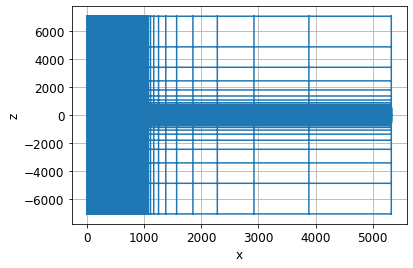

In [6]:
mesh.plot_grid()

In [7]:
print(mesh.n_cells)

33063


In [8]:
inds_casing_x = (
    (mesh.cell_centers[:, 0] > casing_a) & 
    (mesh.cell_centers[:, 0] < casing_b)
)
inds_casing_z = (
    (mesh.cell_centers[:, 2] < casing_l/2) &
    (mesh.cell_centers[:, 2] > -casing_l/2)
)
inds_casing = inds_casing_x & inds_casing_z

In [9]:
sigma = sigma_back * np.ones(mesh.n_cells)
sigma[inds_casing] = sigma_casing

(-600.0, 600.0)

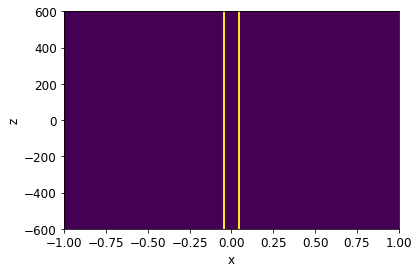

In [10]:
fig, ax = plt.subplots(1, 1)
mesh.plot_image(sigma, pcolor_opts={"norm":LogNorm()}, mirror=True, ax=ax)
ax.set_xlim([-1, 1])
ax.set_ylim(600*np.r_[-1, 1])

## set up a simulation


In [11]:
source = dc.sources.Dipole(location_a=src_a, location_b=src_b)
survey = dc.Survey([source])

In [12]:
sim = dc.Simulation3DCellCentered(
    mesh=mesh,
    sigmaMap=maps.IdentityMap(mesh),
    solver=Pardiso,
    survey=survey,
    bc_type='Dirichlet'
)

In [13]:
%%time
fields = sim.fields(sigma)

CPU times: user 4.49 s, sys: 170 ms, total: 4.66 s
Wall time: 1.21 s


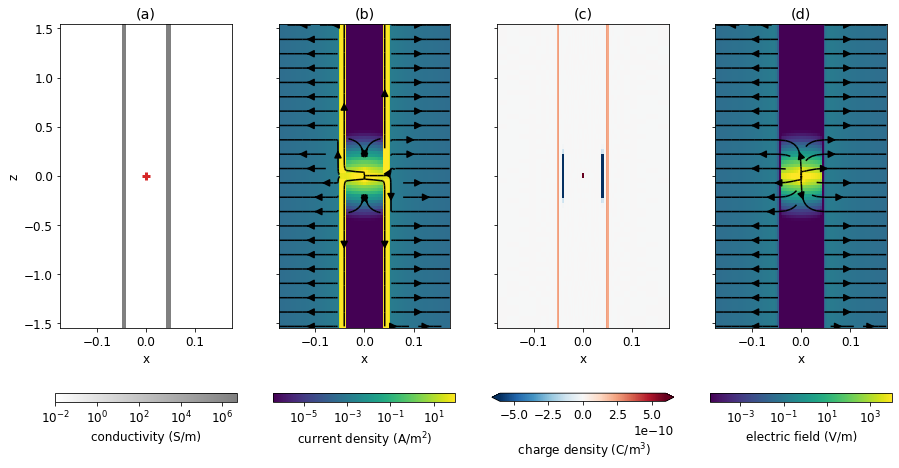

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(15,8), sharex=True, sharey=True)

xlim = 0.175 * np.r_[-1, 1]
zlim = 1.55 * np.r_[-1, 1]

stream_opts={"color":"k", "density":0.75, "arrowsize":1.5}

# model
cmap_model = LinearSegmentedColormap.from_list("my_gray", [(1, 1, 1), (0.5, 0.5, 0.5)], N=1000)
clim_model = np.r_[sigma_back, sigma_casing*1e9]
out = mesh.plot_image(
    sigma,
    pcolor_opts={"cmap":"gray_r", "norm":LogNorm(), "cmap":cmap_model}, 
    ax=ax[0], mirror=True
)
ax[0].set_xlim(xlim)
ax[0].set_ylim(zlim)
ax[0].plot(src_a[0], src_a[2], "C3", marker="+", markersize=8, markeredgewidth=3)
cb = plt.colorbar(out[0], ax=ax[0], orientation="horizontal")
cb.set_label("conductivity (S/m)")

# currents
out = casing_sim.view.plot_cross_section(
    fields,
    view="j",
    ax=ax[1],
    xlim=xlim,
    zlim=zlim,
    clim=np.r_[4e-7, 1e2],
    show_cb=False,
    stream_opts=stream_opts
)
cb = plt.colorbar(out[0], ax=ax[1], orientation="horizontal")
cb.set_label("current density (A/m$^2$)")

# charge density
out = casing_sim.view.plot_cross_section(
    fields,
    view="charge_density",
    ax=ax[2],
    xlim=xlim,
    zlim=zlim,
    clim=6e-10*np.r_[-1, 1], #3e-10
    show_cb=False,
)
cb = plt.colorbar(out[0], ax=ax[2], orientation="horizontal", extend="both")
cb.set_label("\n charge density (C/m$^3$)")

# electric field
out = casing_sim.view.plot_cross_section(
    fields,
    view="e",
    ax=ax[3],
    xlim=xlim,
    zlim=zlim,
    show_cb=False,
    stream_opts=stream_opts,
    clim=np.r_[4e-5, 1e4]
)
cb = plt.colorbar(out[0], ax=ax[3], orientation="horizontal")
cb.set_label("electric field (V/m)")

for i, a in enumerate(ax):
    a.set_aspect(1/5)
    a.set_title(f"({ascii_lowercase[i]})")
    
    if i > 0: 
        a.set_ylabel("")

fig.savefig("figures/kaufman-dc", dpi=200, bbox_inches="tight")